In [1]:
from os import environ

import astropy.io.fits as fits
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from astropy.cosmology import Planck15 as cosmo

from galaxy_cluster_matching import match_galaxies_and_clusters
from completeness_new import calculate_completeness_of_objects
from mass_function import get_weighted_mass_histogram, get_region_volume, get_cluster_volume
from selection_function import get_mass_luminosity_cutoff, get_distance_from_mass, filter_for_selection_function, get_mass_luminosity_histogram
from constants import MASS_BINS, Z_MAX, LOG_MASS_LUMINOSITY_RATIO_BINS

In [2]:
# some parameters for plotting
plt.rcParams.update({
    'font.size': 18,           # Font size for text
    'axes.titlesize': 18,      # Font size for axes titles
    'axes.labelsize': 16,      # Font size for x and y labels
    'xtick.labelsize': 16,     # Font size for x tick labels
    'ytick.labelsize': 16,     # Font size for y tick labels
    'legend.fontsize': 16,     # Font size for legend text
    'figure.figsize': (15, 8), # Default figure size
    'text.usetex': False
})

In [3]:
GAMA_Full_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/gkvScienceCatv02/gkvScienceCatv02.fits')[1].data
GAMA_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/gkvscienceStellarmass_Morphology/fullmerged_gkvscienceStellarmass_Morphologyv02_shrinked.fits')[1].data #galaxy


# eFEDS = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/eFEDS/Mathias_Klug/efeds_members.fit')[1].data    # check of efeds is deeper than erass1
eRASS1 = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/eRASS/merged_primary&optical_clusters/merged_optical_primary_clusters.fits')[1].data #cluster

In [4]:
print(GAMA_raw['flux_rt'])

[2.7199896e-04 1.4143783e-04 5.5088607e-05 ... 6.7270834e-05 3.7947833e-04
 5.1182313e-05]


In [5]:
# Make dataframes

# the survey that has full observation with all different types of objects
gama_full_raw_df_unmasked = pd.DataFrame({
        'uberID': GAMA_Full_raw['uberID'].byteswap().newbyteorder(),
        'uberclass': GAMA_Full_raw['uberclass'].byteswap().newbyteorder(),
        'RA': GAMA_Full_raw['RAcen'].byteswap().newbyteorder(),
        'DEC': GAMA_Full_raw['Deccen'].byteswap().newbyteorder(),
        'z': GAMA_Full_raw['Z'].byteswap().newbyteorder(),
        'duplicate': GAMA_Full_raw['duplicate'].byteswap().newbyteorder(),
        'mask': GAMA_Full_raw['mask'].byteswap().newbyteorder(),
        'starmask': GAMA_Full_raw['starmask'].byteswap().newbyteorder(),
        'flux': GAMA_Full_raw['flux_rt'].byteswap().newbyteorder(), # Jansky
})
# remove all the objects that do not have flux
gama_full_raw_df_unmasked = gama_full_raw_df_unmasked[gama_full_raw_df_unmasked['flux'].notna()]


# the small survey that has all the parameters that we need
gama_df_unmasked = pd.DataFrame({
    'uberID': GAMA_raw['uberID'].byteswap().newbyteorder(),
    'RA': GAMA_raw['RAcen'].byteswap().newbyteorder(),
    'DEC': GAMA_raw['Deccen'].byteswap().newbyteorder(),
    'z': GAMA_raw['Z'].byteswap().newbyteorder(),
    'mstar': GAMA_raw['mstar'].byteswap().newbyteorder(),
    'flux': GAMA_raw['flux_rt'].byteswap().newbyteorder(), # Jansky
    'log_age': GAMA_raw['logage'].byteswap().newbyteorder(),
    'log_met': GAMA_raw['logtau'].byteswap().newbyteorder(),
    'log_met': GAMA_raw['logmet'].byteswap().newbyteorder(),
    'morphology': GAMA_raw['FINAL_CLASS'].byteswap().newbyteorder(),
    'uberclass': GAMA_raw['uberclass'].byteswap().newbyteorder(),  # Add missing columns
    'duplicate': GAMA_raw['duplicate'].byteswap().newbyteorder(),
    'mask': GAMA_raw['mask'].byteswap().newbyteorder(),
    'starmask': GAMA_raw['starmask'].byteswap().newbyteorder(),
    'NQ': GAMA_raw['NQ'].byteswap().newbyteorder(),
})

# Remove rows where flux is NaN
gama_df_unmasked = gama_df_unmasked[gama_df_unmasked['flux'].notna()]   # Jansky
gama_df_unmasked['comoving_distance'] = cosmo.comoving_distance(gama_df_unmasked['z']).value    # Mpc






# load the clusters of galaxies data from the fits object into dataframes
cluster_df_raw = pd.DataFrame({
    'c_ID': eRASS1['DETUID'].byteswap().newbyteorder(),
    'c_NAME': eRASS1['NAME'].byteswap().newbyteorder(),
    'RA': eRASS1['RA'].byteswap().newbyteorder(),
    'DEC': eRASS1['DEC'].byteswap().newbyteorder(),
    'z': eRASS1['BEST_Z'].byteswap().newbyteorder(),
    'z_type': eRASS1['BEST_Z_TYPE_1'].byteswap().newbyteorder(),
    'cluster_radius_kpc': eRASS1['R500'].byteswap().newbyteorder(),
    'cluster_Velocity_Dispersion': eRASS1['VDISP_BOOT'].byteswap().newbyteorder(),
})
cluster_df_raw['cluster_radius_Mpc'] = cluster_df_raw['cluster_radius_kpc'] / 1000
cluster_df_raw['distance'] = cosmo.comoving_distance(cluster_df_raw['z']).value     # Mpc
cluster_df_raw['cluster_volume'] = get_cluster_volume(cluster_df_raw['cluster_radius_Mpc'])


In [6]:
# Masks
# GALAXIES

# BIG GALAXY
# Apply the masks to the GAMA big DataFrame
gama_full_df = gama_full_raw_df_unmasked[
    (gama_full_raw_df_unmasked['uberclass'] == 1) &  # Classified as galaxy
    (gama_full_raw_df_unmasked['duplicate'] == 0) &  # Unique object
    (gama_full_raw_df_unmasked['mask'] == False) &   # Not masked
    (gama_full_raw_df_unmasked['starmask'] == False) &  # Not star-masked
    (gama_full_raw_df_unmasked['z'] < 0.4) &         # Redshift less than 0.4
    (
        ((gama_full_raw_df_unmasked['RA'] > 129.0) & (gama_full_raw_df_unmasked['RA'] < 141.0) & (gama_full_raw_df_unmasked['DEC'] > -2.0) & (gama_full_raw_df_unmasked['DEC'] < 3.0)) |
        ((gama_full_raw_df_unmasked['RA'] > 174.0) & (gama_full_raw_df_unmasked['RA'] < 186.0) & (gama_full_raw_df_unmasked['DEC'] > -3.0) & (gama_full_raw_df_unmasked['DEC'] < 2.0)) |
        ((gama_full_raw_df_unmasked['RA'] > 211.5) & (gama_full_raw_df_unmasked['RA'] < 223.5) & (gama_full_raw_df_unmasked['DEC'] > -2.0) & (gama_full_raw_df_unmasked['DEC'] < 3.0)) |
        ((gama_full_raw_df_unmasked['RA'] > 339.0) & (gama_full_raw_df_unmasked['RA'] < 351.0) & (gama_full_raw_df_unmasked['DEC'] > -35.0) & (gama_full_raw_df_unmasked['DEC'] < -30.0))
    ) &
    (gama_full_raw_df_unmasked['flux'] >= 5.011928e-05)  # Flux greater than or equal to 5.011928e-05
]


# SMALL GALAXY survey masks
gama_df = gama_df_unmasked[
    (gama_df_unmasked['uberclass'] == 1) &           # Classified as galaxy
    (gama_df_unmasked['duplicate'] == 0) &           # Unique object
    (gama_df_unmasked['mask'] == False) &            # Not masked
    (gama_df_unmasked['starmask'] == False) &        # Not star-masked
    (gama_df_unmasked['mstar'] > 0) &                # Stellar mass greater than 0
    (gama_df_unmasked['NQ'] > 2) &                   # Reliable redshift
    (gama_df_unmasked['z'] != 0) &                   # Redshift not zero
    (gama_df_unmasked['z'] != -9.999) &              # Redshift not -9.999 (invalid value)
    (gama_df_unmasked['z'] < Z_MAX) &                # Redshift less than Z_MAX (define Z_MAX)
    (
        ((gama_df_unmasked['RA'] > 129.0) & (gama_df_unmasked['RA'] < 141.0) & (gama_df_unmasked['DEC'] > -2.0) & (gama_df_unmasked['DEC'] < 3.0)) |
        ((gama_df_unmasked['RA'] > 174.0) & (gama_df_unmasked['RA'] < 186.0) & (gama_df_unmasked['DEC'] > -3.0) & (gama_df_unmasked['DEC'] < 2.0)) |
        ((gama_df_unmasked['RA'] > 211.5) & (gama_df_unmasked['RA'] < 223.5) & (gama_df_unmasked['DEC'] > -2.0) & (gama_df_unmasked['DEC'] < 3.0)) |
        ((gama_df_unmasked['RA'] > 339.0) & (gama_df_unmasked['RA'] < 351.0) & (gama_df_unmasked['DEC'] > -35.0) & (gama_df_unmasked['DEC'] < -30.0))
    ) &
    (gama_df_unmasked['flux'] >= 5.011928e-05)       # Flux greater than or equal to 5.011928e-05
]








# CLUSTERS
# Remove rows where 'cluster_Velocity_Dispersion' is NaN
cluster_df_noVelDisp = cluster_df_raw#.dropna(subset=['cluster_Velocity_Dispersion'])

cluster_df = cluster_df_noVelDisp[
    (cluster_df_noVelDisp['z'] <= 0.4) &
    (
        ((cluster_df_noVelDisp['RA'] > 129.0) & (cluster_df_noVelDisp['RA'] < 141.0) & (cluster_df_noVelDisp['DEC'] > -2.0) & (cluster_df_noVelDisp['DEC'] < 3.0)) |
        ((cluster_df_noVelDisp['RA'] > 174.0) & (cluster_df_noVelDisp['RA'] < 186.0) & (cluster_df_noVelDisp['DEC'] > -3.0) & (cluster_df_noVelDisp['DEC'] < 2.0)) |
        ((cluster_df_noVelDisp['RA'] > 211.5) & (cluster_df_noVelDisp['RA'] < 223.5) & (cluster_df_noVelDisp['DEC'] > -2.0) & (cluster_df_noVelDisp['DEC'] < 3.0)) |
        ((cluster_df_noVelDisp['RA'] > 339.0) & (cluster_df_noVelDisp['RA'] < 351.0) & (cluster_df_noVelDisp['DEC'] > -35.0) & (cluster_df_noVelDisp['DEC'] < -30.0))
    ) &

    (cluster_df_noVelDisp['cluster_radius_kpc'] != -1)
]

print(cluster_df_raw.shape)
print(cluster_df.shape)
print(cluster_df_noVelDisp.shape)


(12247, 11)
(70, 11)
(12247, 11)


In [7]:
# Assuming you have all necessary imports and the constants file loaded correctly
gama_df = calculate_completeness_of_objects(gama_full_df, gama_df)

/home/farnoosh/git_repos/Galaxy-Stellar-Mass-Function-in-X-ray-Selected-Clusters/completeness_new.py:23: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/home/farnoosh/git_repos/Galaxy-Stellar-Mass-Function-in-X-ray-Selected-Clusters/completeness_new.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_survey["completeness"] = object_completeness


In [8]:
# LOOOOOOOOOOOOONG
# match the galaxies with the clusters
matched_gama_dataframe = match_galaxies_and_clusters(galaxy_dataframe=gama_df, cluster_dataframe=cluster_df)
matched_gama_dataframe.to_csv('gama_matched_in_erass1.csv')

Progress: 0.0065390106476890045%

/home/farnoosh/git_repos/Galaxy-Stellar-Mass-Function-in-X-ray-Selected-Clusters/galaxy_cluster_matching.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  galaxy_dataframe['environment'] = "Field"
/home/farnoosh/git_repos/Galaxy-Stellar-Mass-Function-in-X-ray-Selected-Clusters/galaxy_cluster_matching.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  galaxy_dataframe['cluster_mass'] = None
/home/farnoosh/git_repos/Galaxy-Stellar-Mass-Function-in-X-ray-Selected-Clusters/galaxy_cluster_matching.py:66: Se

Progress: 0.5361988731104984%%%

/home/farnoosh/git_repos/Galaxy-Stellar-Mass-Function-in-X-ray-Selected-Clusters/galaxy_cluster_matching.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  galaxy_dataframe.at[i, 'cluster_radius'] = cluster['cluster_radius_Mpc']


Progress: 201.682160489118%6%

In [9]:
# load matched galaxies
gama_df = pd.read_csv('gama_matched_in_erass1.csv')

/tmp/ipykernel_10180/3435411683.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  gama_df = pd.read_csv('gama_matched_in_erass1.csv')


In [10]:
print(gama_df)

        Unnamed: 0           uberID          RA       DEC        z  \
0                0  128980017205121  129.567355 -1.601051  0.07561   
1                1  128980023507290  129.561380 -1.396778  0.05738   
2                2  128980121111035  129.469375 -1.044192  0.07918   
3                3  128980163907821  129.428660 -1.346991  0.04838   
4                4  128980185304614  129.409060 -1.648810  0.05364   
...            ...              ...         ...       ...      ...   
183509      370101  179990595910710  180.022271 -0.074880  0.08144   
183510      370110  222980880703442  222.753969 -1.759161  0.20127   
183511      370112  215020496300092  214.716076  1.925282  0.26861   
183512      370113  137021074202062  136.971637  2.110832  0.27823   
183513      370115  176980454003053  177.155905 -1.795873  0.29592   

               mstar      flux   log_age   log_met morphology  ...  duplicate  \
0       8.674012e+09  0.000272  9.386167 -2.656237          E  ...      False 

In [16]:
counts = gama_df['environment'].value_counts()
ratio = counts.get('ClusterMember', 0) / counts.get('Field', 1) * 100  # Percent
print(f"ClusterMember: {counts.get('ClusterMember', 0)}, Field: {counts.get('Field', 0)}, Ratio: {ratio:.10f}%")


ClusterMember: 1530, Field: 181984, Ratio: 0.8407332513%


In [18]:
# apply selection function
mass_to_light_histogram_all_galaxies = get_mass_luminosity_histogram(galaxy_df=gama_df)

mstar: 8674012000.0, Luminosity: 4472741634.264639, Mass-to-Light Ratio: 1.9393053990756812
mstar: 2056488600.0, Luminosity: 1351296537.304677, Mass-to-Light Ratio: 1.5218632944193826
mstar: 520908960.0, Luminosity: 991720583.4433811, Mass-to-Light Ratio: 0.5252577880266811
mstar: 13092252000.0, Luminosity: 5349733073.421444, Mass-to-Light Ratio: 2.4472720078399717
mstar: 733718000.0, Luminosity: 506177554.5551491, Mass-to-Light Ratio: 1.449526936540723
mstar: 22015638000.0, Luminosity: 8567081351.467544, Mass-to-Light Ratio: 2.5697944371951964
mstar: 112884000000.0, Luminosity: 44207966651.69831, Mass-to-Light Ratio: 2.553476410470994
mstar: 27444124000.0, Luminosity: 10324849850.728083, Mass-to-Light Ratio: 2.6580651919179927
mstar: 350003500.0, Luminosity: 537370119.142457, Mass-to-Light Ratio: 0.6513266881279901
mstar: 9233943000.0, Luminosity: 5672013444.548463, Mass-to-Light Ratio: 1.6279832708921047
mstar: 657660860.0, Luminosity: 559329199.29508, Mass-to-Light Ratio: 1.17580283

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
mass_to_light_histogram_low_mass_galaxies = get_mass_luminosity_histogram(galaxy_df=gama_df[gama_df["mstar"] < 10**10])
mass_luminosity_cutoff = get_mass_luminosity_cutoff(gama_df, cut_off_percentage=80)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



mstar: 88859390000.0, Luminosity: 29099179019.440315, Mass-to-Light Ratio: 3.053673436650416
mstar: 191615010000.0, Luminosity: 37895008348.08638, Mass-to-Light Ratio: 5.0564709800275365
mstar: 39993660000.0, Luminosity: 14663561396.287378, Mass-to-Light Ratio: 2.72741791159451
mstar: 48994406000.0, Luminosity: 13078416273.171406, Mass-to-Light Ratio: 3.746203284606055
mstar: 26323149000.0, Luminosity: 6990718135.93368, Mass-to-Light Ratio: 3.7654427611226073
mstar: 31538630000.0, Luminosity: 21061340539.031685, Mass-to-Light Ratio: 1.4974654600713284
mstar: 8689394000.0, Luminosity: 15278902175.024395, Mass-to-Light Ratio: 0.5687184786223769
mstar: 15812112000.0, Luminosity: 8884689515.43243, Mass-to-Light Ratio: 1.7797033844046943
mstar: 154659320000.0, Luminosity: 42497711697.831314, Mass-to-Light Ratio: 3.6392387688933465
mstar: 178131060000.0, Luminosity: 34021661918.810017, Mass-to-Light Ratio: 5.235813007168655
mstar: 43671740000.0, Luminosity: 17602178261.22007, Mass-to-Light R

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [20]:
mass_bin_selection_function = np.logspace(5,12.25, 1000)
# mass_for_richards_curve = np.logspace(5,12.25, 1000)

selection_function = get_distance_from_mass(mass_bin_selection_function, log_cutoff_mass_to_light_ratio=mass_luminosity_cutoff)

gama_df['within_selection_function'] = gama_df.apply(
    lambda row: filter_for_selection_function(selection_function, mass_bin_selection_function, row['mstar'],
                                              row['comoving_distance']), axis=1)
# find the general mass function
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(gama_df[gama_df['within_selection_function']],
                                                                   region_name='G09')
stellar_mass_function = mass_histogram / get_region_volume('G09', MASS_BINS[:-1], mass_luminosity_cutoff)
stellar_mass_function_error = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1], mass_luminosity_cutoff)

In [23]:
# find the cluster mass function

def get_cluster_volume_sum_from_mass(mass, cluster_df, z_min=0, z_max=0.4, log_cutoff_mass_to_light_ratio=None):
    # If log_cutoff_mass_to_light_ratio is provided, use it; otherwise, use some default behavior
    cut_off_distance = get_distance_from_mass(mass, log_cutoff_mass_to_light_ratio)
    reduced_cluster_dataframe = cluster_df[(cluster_df['distance'] <= cut_off_distance) & (cluster_df['z'] >= z_min) & (cluster_df['z'] <= z_max)]
    print(f'for mass {mass} we have {reduced_cluster_dataframe.shape[0]} clusters')
    return sum(reduced_cluster_dataframe["cluster_volume"])


cluster_volumes_by_mass_bin = [
    get_cluster_volume_sum_from_mass(mass=mass, cluster_df=cluster_df, z_max=0.4,
                                     log_cutoff_mass_to_light_ratio=mass_luminosity_cutoff)
    for mass in MASS_BINS
]


for mass 100000.0 we have 0 clusters
for mass 177827.94100389228 we have 0 clusters
for mass 316227.7660168379 we have 0 clusters
for mass 562341.3251903491 we have 0 clusters
for mass 1000000.0 we have 0 clusters
for mass 1778279.410038923 we have 0 clusters
for mass 3162277.6601683795 we have 0 clusters
for mass 5623413.251903491 we have 0 clusters
for mass 10000000.0 we have 0 clusters
for mass 17782794.100389227 we have 0 clusters
for mass 31622776.60168379 we have 0 clusters
for mass 56234132.51903491 we have 0 clusters
for mass 100000000.0 we have 0 clusters
for mass 177827941.00389227 we have 0 clusters
for mass 316227766.01683795 we have 0 clusters
for mass 562341325.1903491 we have 0 clusters
for mass 1000000000.0 we have 4 clusters
for mass 1778279410.0389228 we have 4 clusters
for mass 3162277660.1683793 we have 4 clusters
for mass 5623413251.903491 we have 4 clusters
for mass 10000000000.0 we have 7 clusters
for mass 17782794100.38923 we have 8 clusters
for mass 31622776601

In [24]:
# and cluster galaxies
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(gama_df[(gama_df["within_selection_function"] == True) & (gama_df["environment"] == "ClusterMember")],region_name='G09')
print(mass_histogram)
print(cluster_volumes_by_mass_bin)
stellar_mass_function_cluster = mass_histogram[7:] / cluster_volumes_by_mass_bin[8:]
stellar_mass_function_error_cluster = mass_histogram_error[7:] / cluster_volumes_by_mass_bin[8:]

[   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
   19.44697609   19.41933829    9.69631095   19.39408506  106.88847074
  194.2018742   194.43498758  837.51502173 1051.78292431  583.58589162
  410.22212035  301.70810601   38.85779359]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.9405996293589145, 2.9405996293589145, 2.9405996293589145, 2.9405996293589145, 7.306299484491987, 7.8393796998161545, 20.08749873482756, 43.978460976600545, 76.15770492072078, 103.07116348790736, 167.4172141836344, 167.4172141836344, 167.4172141836344]


/tmp/ipykernel_10180/1404237667.py:5: RuntimeWarning: invalid value encountered in divide
  stellar_mass_function_cluster = mass_histogram[7:] / cluster_volumes_by_mass_bin[8:]
/tmp/ipykernel_10180/1404237667.py:6: RuntimeWarning: invalid value encountered in divide
  stellar_mass_function_error_cluster = mass_histogram_error[7:] / cluster_volumes_by_mass_bin[8:]


Text(0, 0.5, 'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{-3}$)')

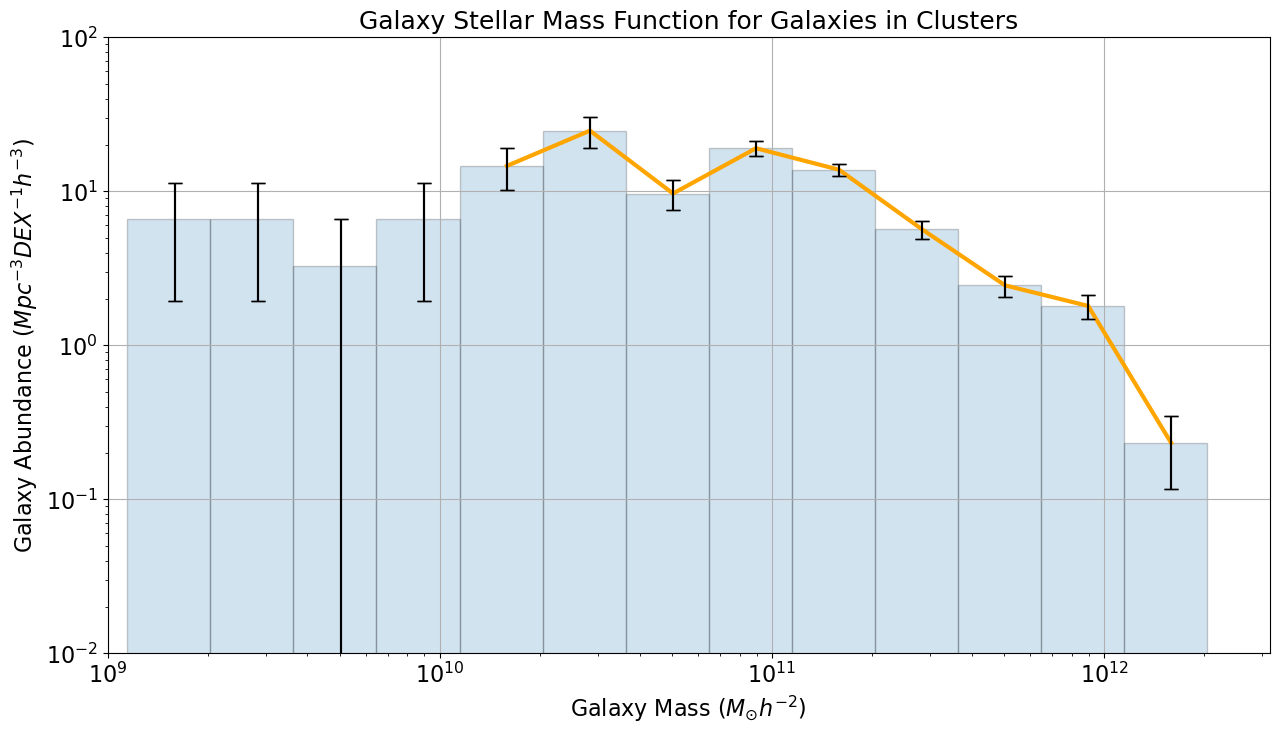

In [33]:
# plot the cluster function
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_cluster, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_cluster, capsize=5, alpha=0.2)

plt.plot(bin_centers[19:] / 0.7**2, stellar_mass_function_cluster[12:], color='orange', linewidth=3)
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_cluster, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_cluster, capsize=5, alpha=0.0)

plt.xscale('log'); plt.yscale('log')
plt.xlim(10**9, 10**12.5)
plt.ylim(10**-2, 10**2)
plt.grid()

plt.title("Galaxy Stellar Mass Function for Galaxies in Clusters")
plt.xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
plt.ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{-3}$)')
# plt.savefig("../plots/mass_function_cluster_galaxies.pdf")

Text(0, 0.5, 'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')

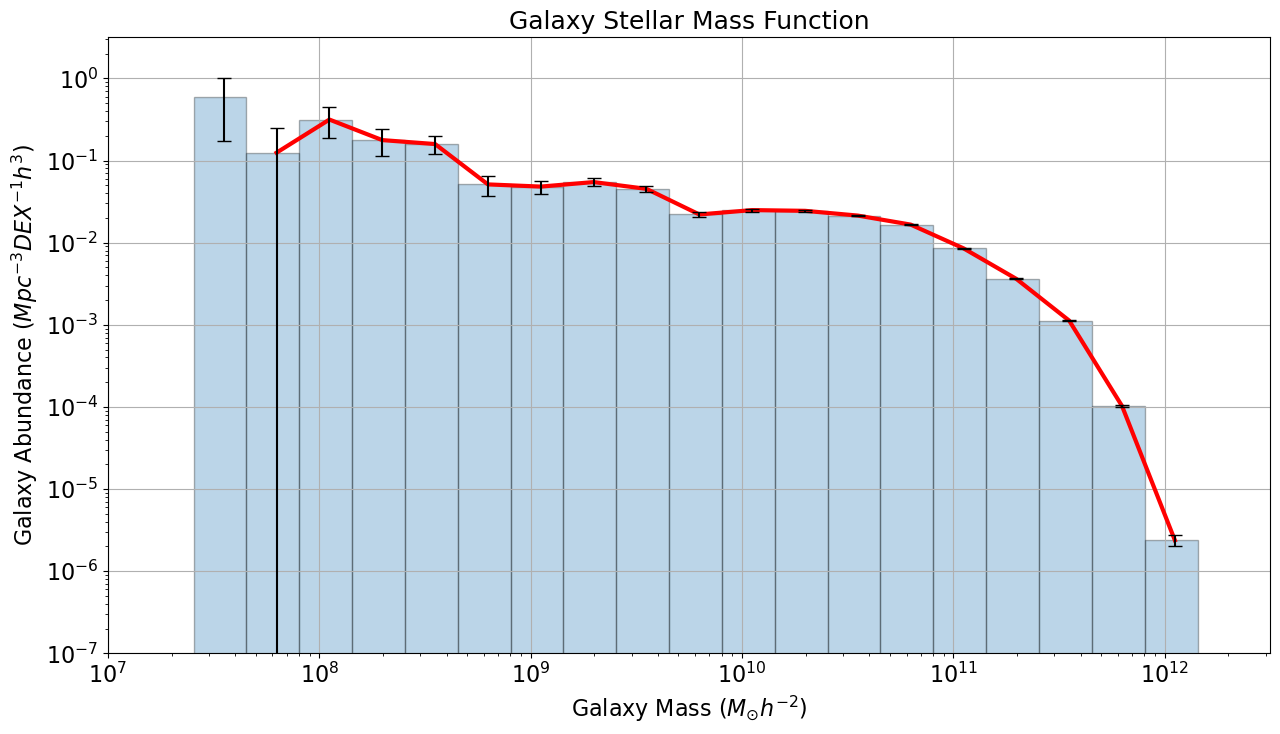

In [29]:
# plot the general mass function

bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])
plt.bar(bin_centers / 0.7, stellar_mass_function * 0.7**3, width=np.diff(MASS_BINS) / 0.7, edgecolor='black', capsize=5, alpha=0.3)

plt.plot(bin_centers[10:] / 0.7, stellar_mass_function[10:] * 0.7**3, color='red', linewidth=3, label="This Work z < 0.4")
plt.bar(bin_centers / 0.7, stellar_mass_function * 0.7**3, width=np.diff(MASS_BINS) / 0.7, edgecolor='black', yerr=stellar_mass_function_error * 0.7**3, capsize=5, alpha=0.0)

plt.xscale('log'); plt.yscale('log')
plt.xlim(10**7, 10**12.5)
plt.ylim(10**-7, 10**0.5)
plt.grid()

plt.title("Galaxy Stellar Mass Function")
plt.xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
plt.ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')
# plt.savefig("../plots/mass_function_alone.pdf")